Вопросы:

1. Что такое KL-criterion для модели?

In [4]:
!pip install torchbnn 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

drive.mount("/content/drive")

#warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

Mounted at /content/drive


#### 1. Скачивание и распаковка датасета.

In [6]:
!git clone https://github.com/mmalekzadeh/motion-sense.git

Cloning into 'motion-sense'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 612 (delta 4), reused 4 (delta 4), pack-reused 605
Receiving objects: 100% (612/612), 201.77 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (296/296), done.


разархивируем в content все его части (также есть на моем гугл-диске по адресу /content/drive/MyDrive/metric_analysis/datasets/motion-sense) (/content/)

In [7]:
!cp /content/motion-sense/data/data_subjects_info.csv -d .
!unzip -q /content/motion-sense/data/A_DeviceMotion_data.zip -d .
!unzip -q /content/motion-sense/data/B_Accelerometer_data.zip -d .
!unzip -q /content/motion-sense/data/C_Gyroscope_data.zip -d .

In [8]:
# !cp /content/motion-sense/data/* /content/drive/MyDrive/metric_analysis/datasets/motion-sense
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/A_DeviceMotion_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/B_Accelerometer_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/C_Gyroscope_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/

Из датасета с большим количеством измерений берем только "userAcceleration" во время ходьбы "wlk"

In [9]:
freq = 50 # частота замера = 50ГЦ

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration"] # attitude, gravity, rotationRate, userAcceleration
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ["wlk"] # ACT_LABELS [2:3]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
print(dt_list)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['userAcceleration']
[INFO] -- Selected activites: ['wlk']
[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(344288, 10)


,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,0.091702,0.415881,0.093689,0.0,0.0,102.0,188.0,46.0,1.0,7.0
1,0.367412,0.004566,-0.106082,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2,0.172093,-0.217483,-0.163387,0.0,0.0,102.0,188.0,46.0,1.0,7.0
3,0.004957,-0.237566,-0.019080,0.0,0.0,102.0,188.0,46.0,1.0,7.0
4,-0.040292,-0.241461,0.015201,0.0,0.0,102.0,188.0,46.0,1.0,7.0


Возьмем userAcceleration по x-y для id=0.0 (первый участник) и далее будем использовать его


In [10]:
first_user_data = dataset[dataset['id'] == 0.0]
first_user_data

,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,0.091702,0.415881,0.093689,0.0,0.0,102.0,188.0,46.0,1.0,7.0
1,0.367412,0.004566,-0.106082,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2,0.172093,-0.217483,-0.163387,0.0,0.0,102.0,188.0,46.0,1.0,7.0
3,0.004957,-0.237566,-0.019080,0.0,0.0,102.0,188.0,46.0,1.0,7.0
4,-0.040292,-0.241461,0.015201,0.0,0.0,102.0,188.0,46.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...
11107,0.045689,0.611858,-0.873182,0.0,0.0,102.0,188.0,46.0,1.0,15.0
11108,0.404748,1.027273,-0.621450,0.0,0.0,102.0,188.0,46.0,1.0,15.0
11109,0.407576,0.258908,-0.084899,0.0,0.0,102.0,188.0,46.0,1.0,15.0
11110,0.230798,-0.047420,0.175331,0.0,0.0,102.0,188.0,46.0,1.0,15.0


In [11]:
first_user_data.describe()

,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
count,11112.000000,11112.000000,11112.000000,11112.0,11112.0,11112.0,11112.0,11112.0,11112.0,11112.000000
mean,0.059449,0.177968,-0.259180,0.0,0.0,102.0,188.0,46.0,1.0,8.350252
std,0.492574,0.639860,0.512329,0.0,0.0,0.0,0.0,0.0,0.0,2.499083
min,-3.330301,-1.645164,-2.616230,0.0,0.0,102.0,188.0,46.0,1.0,7.000000
25%,-0.226270,-0.314715,-0.573816,0.0,0.0,102.0,188.0,46.0,1.0,7.000000
50%,0.078264,0.139191,-0.226753,0.0,0.0,102.0,188.0,46.0,1.0,8.000000
75%,0.391761,0.601875,0.085896,0.0,0.0,102.0,188.0,46.0,1.0,8.000000
max,1.968308,2.708035,1.518116,0.0,0.0,102.0,188.0,46.0,1.0,15.000000


#### 2. Визуализация  данных

In [12]:
x_acc = first_user_data['userAcceleration.x']
sec_times = np.arange(len(x_acc)) / freq

vis_mask = (sec_times < 10) # покажем только первые 10 сек

fig = go.Figure()
fig.add_trace(go.Scatter(x=sec_times[vis_mask],
                            y = x_acc[vis_mask],
                            mode='lines', 
                            name='x_acc'))

fig.update_layout(
    title="User#0 x-acceleration during walking",
    xaxis_title="time, sec",
    yaxis_title="Acceleration",
    legend_title="Legend Title",
    font=dict(
        family="DejaVu Serif",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### 3. Изменение частоты и использование 2NN для восстановления

In [13]:
!pip install geotorch -q

from drive.MyDrive.metric_analysis.modules.classes_and_functions import *
from drive.MyDrive.metric_analysis.modules.model_arch import *
from drive.MyDrive.metric_analysis.modules.visualization import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 KB 2.4 MB/s eta 0:00:00


Приближенно (да и из графика видно) считаем, что 1 шаг совершается за 1 секунду.

Тогда 2 шага занимают 2 секунды. Именно такое время мы и будем восстанавливать

In [14]:
period = 2 # 2 секунды мы даем на вход модели

steps_in_time = period * freq # сколько моментов времени в периуде
print(steps_in_time)

100


In [47]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0.01, prior_sigma=0.1, in_features=in_len, out_features=hid_dim),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0.01, prior_sigma=0.1, in_features=hid_dim, out_features=out_len),
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
kl_criterion = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cpu


In [48]:
def common_criterion(*pars):
    l1 = criterion(*pars)
    l2 = kl_criterion(model) * 0.01
    return l1 + l2

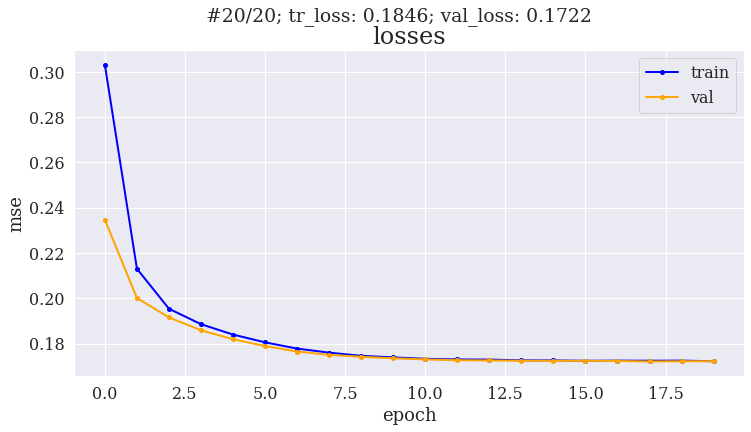

In [49]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = common_criterion,
    epochs=20,
    draw_every=10,
    separate_show=False,
    device=device
)

In [50]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device)

In [46]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device)

In [51]:
model

Sequential(
  (0): BayesLinear(prior_mu=0.01, prior_sigma=0.1, in_features=100, out_features=3, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0.01, prior_sigma=0.1, in_features=3, out_features=100, bias=True)
)

In [52]:
model[0]

BayesLinear(prior_mu=0.01, prior_sigma=0.1, in_features=100, out_features=3, bias=True)

In [55]:
learned_mu = model[0].weight_mu
learned_logsigma = model[0].weight_log_sigma

In [57]:
learned_mu.shape

torch.Size([3, 100])

In [59]:
learned_logsigma.shape

torch.Size([3, 100])

In [ ]:
for step in range(3000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))